<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/GET_FII_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance


     |████████████████████████████████| 6.3 MB 5.9 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=926824952ed7948242e4b58957deb1d8975aadc364291691e4cb1ad4b08aa06a
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import yfinance as yf

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import pandas as pd



In [4]:
nifty=yf.download('^NSEI',start='2018-08-08')
nif=nifty.reset_index()

[*********************100%***********************]  1 of 1 completed


In [5]:
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator

In [6]:
content='https://raw.githubusercontent.com/anirbanghoshsbi/data/main/'

In [7]:
data1=pd.read_csv(content+'fii1.txt',sep='\t',header=None)
data2=pd.read_csv(content+'fii2.txt',sep='\t',header=None)
data3=pd.read_csv(content+'fii3.txt',sep='\t',header=None)
data4=pd.read_csv(content+'fii4.txt',sep='\t',header=None)
data5=pd.read_csv(content+'fii5.txt',sep='\t',header=None)
data6=pd.read_csv(content+'fii6.txt',sep='\t',header=None)
data7=pd.read_csv(content+'fii7.txt',sep='\t',header=None)
data8=pd.read_csv(content+'fii8.txt',sep='\t',header=None)


In [8]:
data=[]

In [9]:
data=data1[0].tolist()
data.extend(data2[0].tolist())
data.extend(data3[0].tolist())
data.extend(data4[0].tolist())
data.extend(data5[0].tolist())
data.extend(data6[0].tolist())
data.extend(data7[0].tolist())
data.extend(data8[0].tolist())

In [10]:
len(data)

5474

In [11]:
lst=[]
lst.append(data[0:7])

In [12]:
for i in range(7,len(data)):
  if i%7==0:
    #print(i)
    lst.append(data[i:i+7])




In [13]:
df=pd.DataFrame()

In [14]:
for item in lst:
  to_append=item
  a_series = pd.Series(to_append)
  df = df.append(a_series, ignore_index=True)


In [15]:
df.to_csv('fii.csv')

In [16]:
fii_fig= pd.read_csv('/content/fii.csv')
fii=pd.read_csv('/content/fii.csv')
fii=fii[::-1]

In [17]:
fii_fig=fii_fig[::-1]

In [18]:
fii_fig.columns =['Index','Date','FIIcall','FIIput','FIIFuture','FIIFutOI','FIICash','DIIcash']
fii.columns =['Index','Date','FIIcall','FIIput','FIIFuture','FIIFutOI','FIICash','DIIcash']

In [19]:
fii_fig.drop('Index',inplace=True,axis=1)

In [20]:
fii_fig=fii_fig.set_index('Date')

In [21]:
len(fii),len(nif)

(782, 780)

# Change Here

In [22]:
fii=fii.reset_index()
# download nifty price and concat with fii data
fii=fii.join(nif.Close)
fii.Close=fii.Close.shift(1)

In [23]:
fii.tail(2)

,index,Index,Date,FIIcall,FIIput,FIIFuture,FIIFutOI,FIICash,DIIcash,Close
780,1,1,13 Oct 2021,16.2,-14.1,1205,12854,937,-432,18338.550781
781,0,0,14 Oct 2021,-3.2,-0.1,1327,13807,1682,-1751,NaN


In [24]:
fii_fig['Cash']=fii_fig.FIICash+fii_fig.DIIcash

In [25]:
fii_fig['macdfut']=fii_fig['FIIFuture'].ewm(span=150, adjust=False).mean()-fii_fig['FIIFuture'].ewm(span=300, adjust=False).mean()
fii_fig['signalfut']=fii_fig['macdfut'].ewm(span=95,adjust=False).mean()
fii_fig['signal10fut']=fii_fig['macdfut'].ewm(span=20,adjust=False).mean()
fii_fig['histfut']=fii_fig['macdfut']-fii_fig['signalfut']

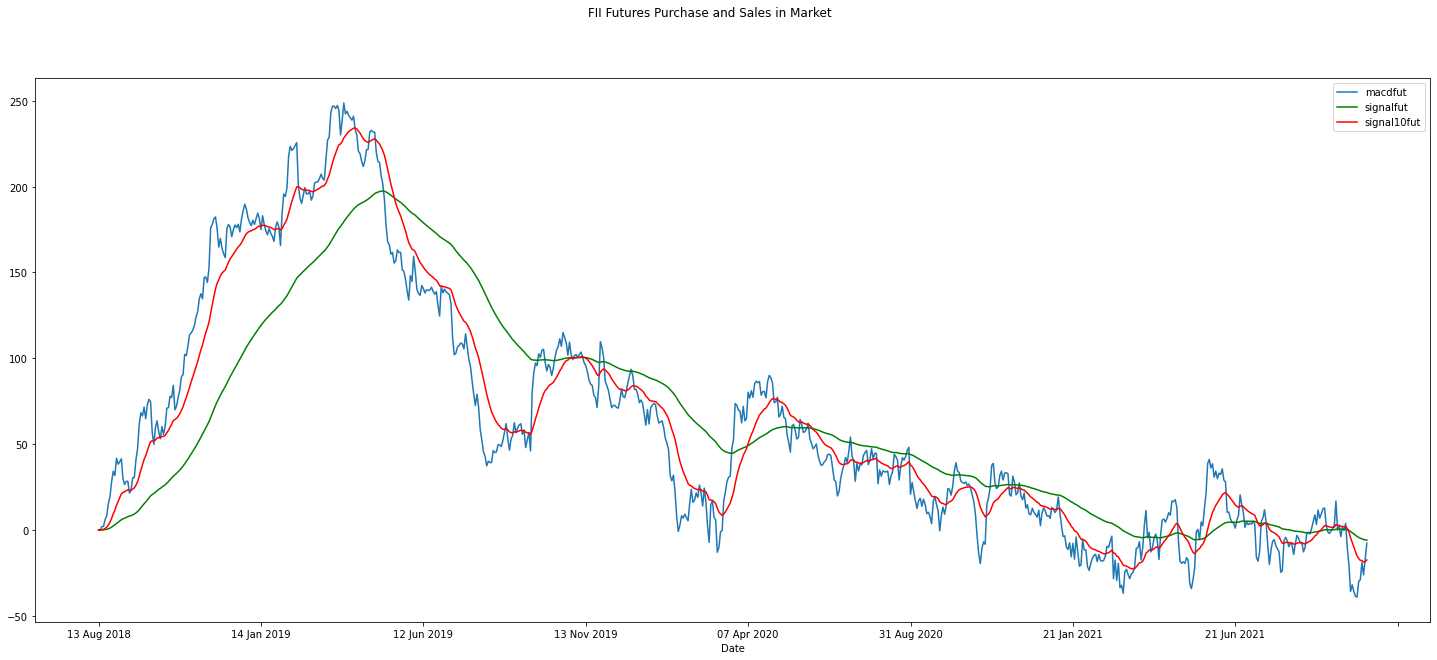

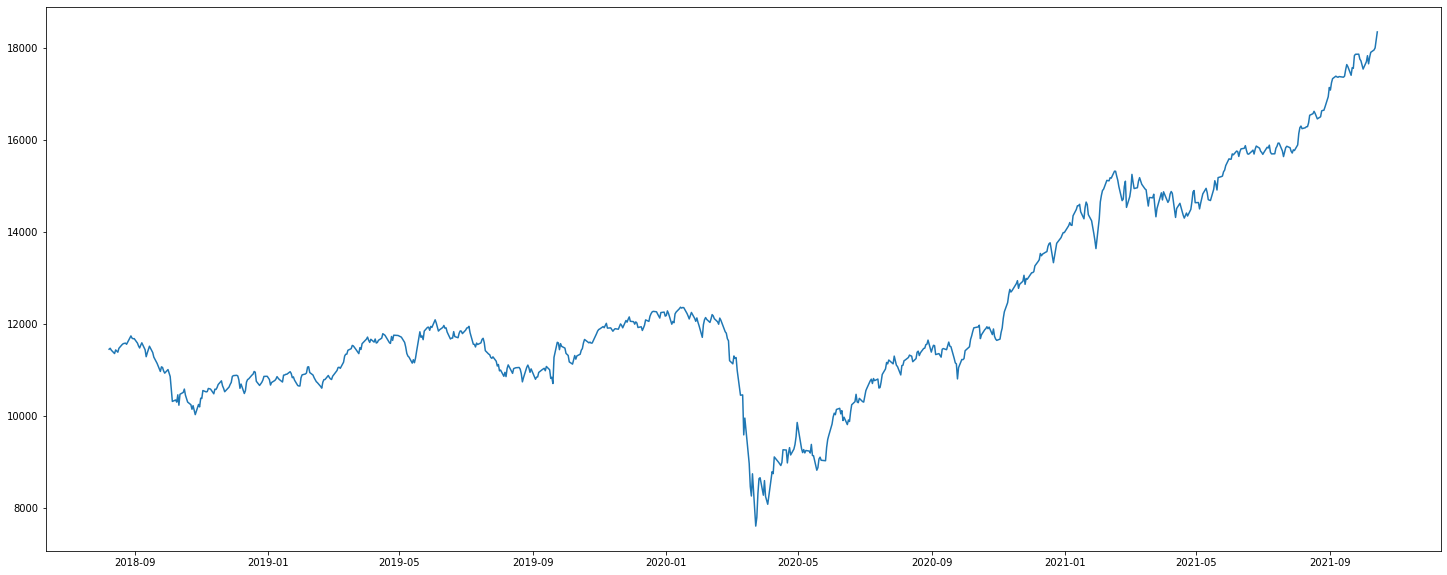

In [26]:
fii_fig['macdfut'].plot(figsize=(25,10))
fii_fig['signalfut'].plot(color='g')
fii_fig['signal10fut'].plot(color='r')
#plt.plot(fii_fig.loc[:, :].index)
plt.suptitle('FII Futures Purchase and Sales in Market')
plt.legend()
plt.show()
plt.figure(figsize=(25,10))
plt.plot(nifty.Close)
plt.show()

# Plot FII minus DII

In [27]:
fii_fig['macdy']=fii_fig['Cash'].ewm(span=50, adjust=False).mean()-fii_fig['Cash'].ewm(span=100, adjust=False).mean()
fii_fig['signaly']=fii_fig['macdy'].ewm(span=25,adjust=False).mean()
fii_fig['signal10y']=fii_fig['macdy'].ewm(span=10,adjust=False).mean()
fii_fig['histy']=fii_fig['macdy']-fii_fig['signaly']

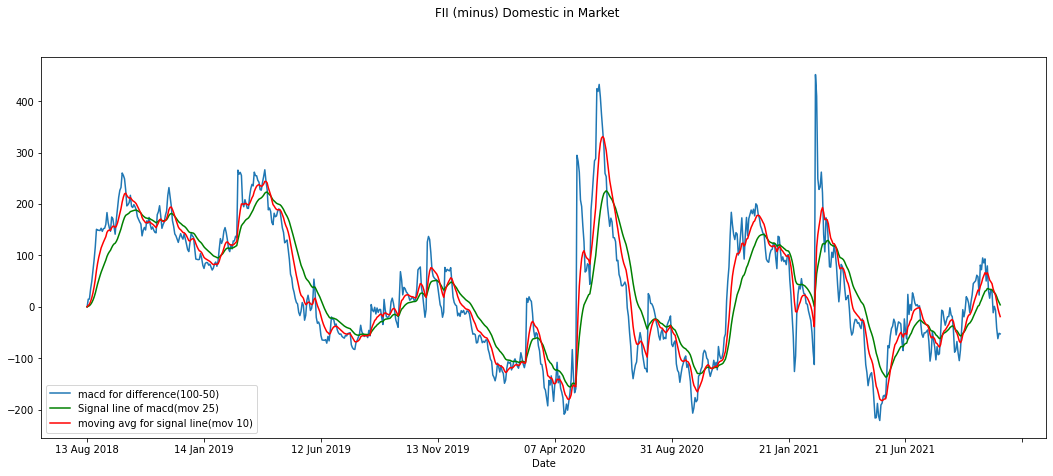

In [28]:
fii_fig['macdy'].plot(figsize=(18,7),label= 'macd for difference(100-50)')
fii_fig['signaly'].plot(color='g',label='Signal line of macd(mov 25)')
fii_fig['signal10y'].plot(color='r',label='moving avg for signal line(mov 10)')
#plt.plot(fii_fig.loc[:, :].index)
plt.suptitle('FII (minus) Domestic in Market')
plt.legend(loc='lower left')
plt.show()

In [29]:
fii_fig['macdy']=fii_fig['Cash'].ewm(span=100, adjust=False).mean()-fii_fig['Cash'].ewm(span=250, adjust=False).mean()
fii_fig['signaly']=fii_fig['macdy'].ewm(span=45,adjust=False).mean()
fii_fig['signal10y']=fii_fig['macdy'].ewm(span=20,adjust=False).mean()
fii_fig['histy']=fii_fig['macdy']-fii_fig['signaly']

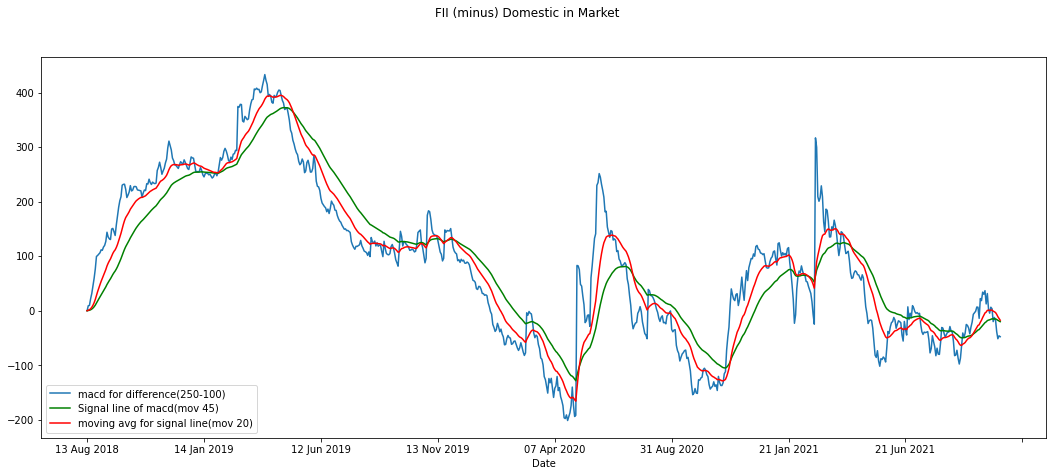

In [30]:
fii_fig['macdy'].plot(figsize=(18,7),label= 'macd for difference(250-100)')
fii_fig['signaly'].plot(color='g',label='Signal line of macd(mov 45)')
fii_fig['signal10y'].plot(color='r',label='moving avg for signal line(mov 20)')
#plt.plot(fii_fig.loc[:, :].index)
plt.suptitle('FII (minus) Domestic in Market')
plt.legend(loc='lower left')
plt.show()

In [31]:
fii_fig['macd']=fii_fig['DIIcash'].ewm(span=50, adjust=False).mean()-fii_fig['DIIcash'].ewm(span=200, adjust=False).mean()
fii_fig['signal']=fii_fig['macd'].ewm(span=35,adjust=False).mean()
fii_fig['signal10']=fii_fig['macd'].ewm(span=10,adjust=False).mean()
fii_fig['hist']=fii_fig['macd']-fii_fig['signal']

In [32]:
fii_fig['macdx']=fii_fig['FIICash'].ewm(span=50, adjust=False).mean()-fii_fig['FIICash'].ewm(span=200, adjust=False).mean()
fii_fig['signalx']=fii_fig['macdx'].ewm(span=35,adjust=False).mean()
fii_fig['signal10x']=fii_fig['macdx'].ewm(span=10,adjust=False).mean()
fii_fig['histx']=fii_fig['macdx']-fii_fig['signalx']

# Plot FII , DII , Difference comparison

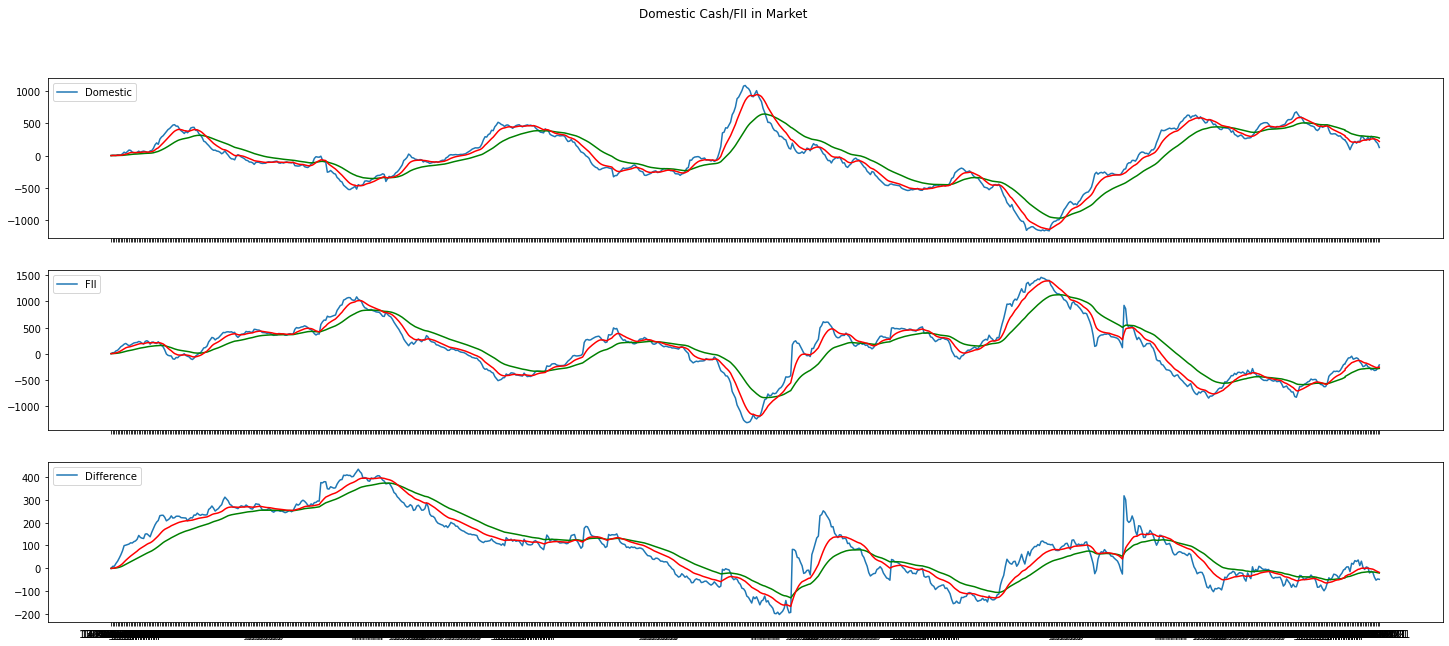

No handles with labels found to put in legend.


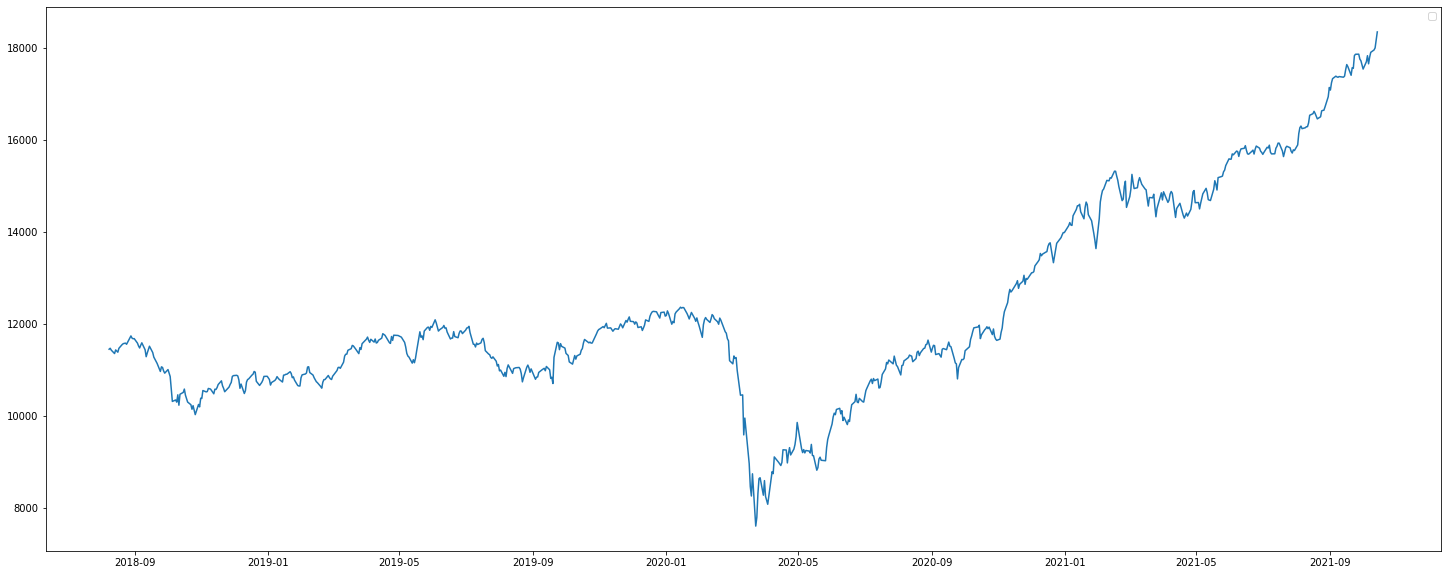

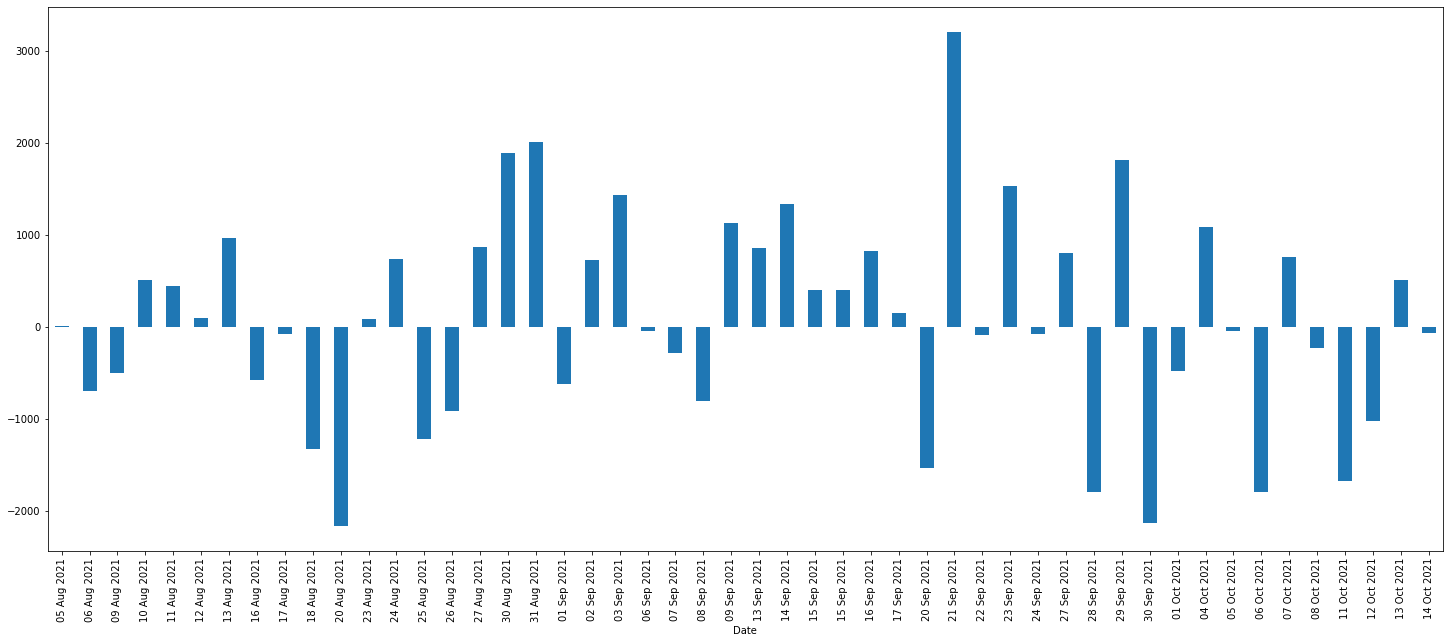

In [33]:
fig,ax=plt.subplots(3,1,figsize=(25,10),sharex=True)
ax[0].plot(fii_fig['macd'], label='Domestic')
ax[0].plot(fii_fig['signal'],color='g')
ax[0].plot(fii_fig['signal10'],color='r')
ax[2].plot(fii_fig['macdy'],label='Difference')
ax[2].plot(fii_fig['signaly'],color='g')
ax[2].plot(fii_fig['signal10y'],color='r')
#plt.plot(fii_fig.loc[:, :].index)
ax[1].plot(fii_fig['macdx'],label='FII')
ax[1].plot(fii_fig['signalx'],color='g')
ax[1].plot(fii_fig['signal10x'],color='r')

#plt.plot(fii_fig.loc[:, :].index)
plt.suptitle('Domestic Cash/FII in Market')
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[2].legend(loc='upper left')
plt.show()
plt.figure(figsize=(25,10))
plt.plot(nifty.Close)
#plt.xaxis.set_major_locator(mloc)
plt.legend()
plt.show()
plt.figure(figsize=(25,10))
fii_fig['Cash'][-50:].plot.bar()
plt.show()

In [34]:
fii_fig.tail(2)

,FIIcall,FIIput,FIIFuture,FIIFutOI,FIICash,DIIcash,Cash,macdfut,signalfut,signal10fut,histfut,macdy,signaly,signal10y,histy,macd,signal,signal10,hist,macdx,signalx,signal10x,histx
Date,,,,,,,,,,,,,,,,,,,,,,,
13 Oct 2021,16.2,-14.1,1205,12854,937,-432,505,-17.235477,-5.807687,-18.478006,-11.427791,-46.100169,-18.847596,-14.295804,-27.252573,188.010990,280.689800,238.545206,-92.678810,-277.536415,-287.784511,-268.129163,10.248096
14 Oct 2021,-3.2,-0.1,1327,13807,1682,-1751,-69,-7.754182,-5.848239,-17.456689,-1.905943,-47.700191,-20.102056,-17.477175,-27.598134,124.908457,272.035281,217.883979,-147.126824,-216.901519,-283.846567,-258.815046,66.945048


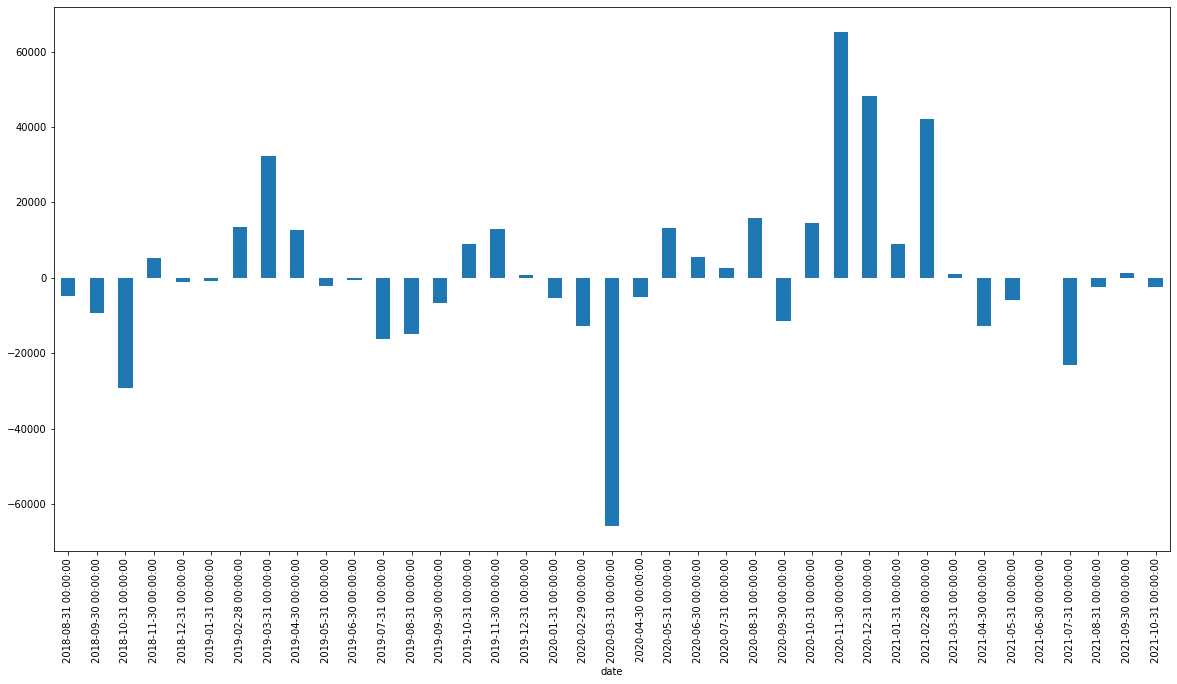

In [35]:
fii_fig=fii_fig.reset_index()
fii_fig['date']=pd.to_datetime(fii_fig['Date'])
fii_fig = fii_fig.set_index('date')
fii_fig.FIICash.resample('M').sum().plot(kind='bar',figsize=(20,10))
plt.show()

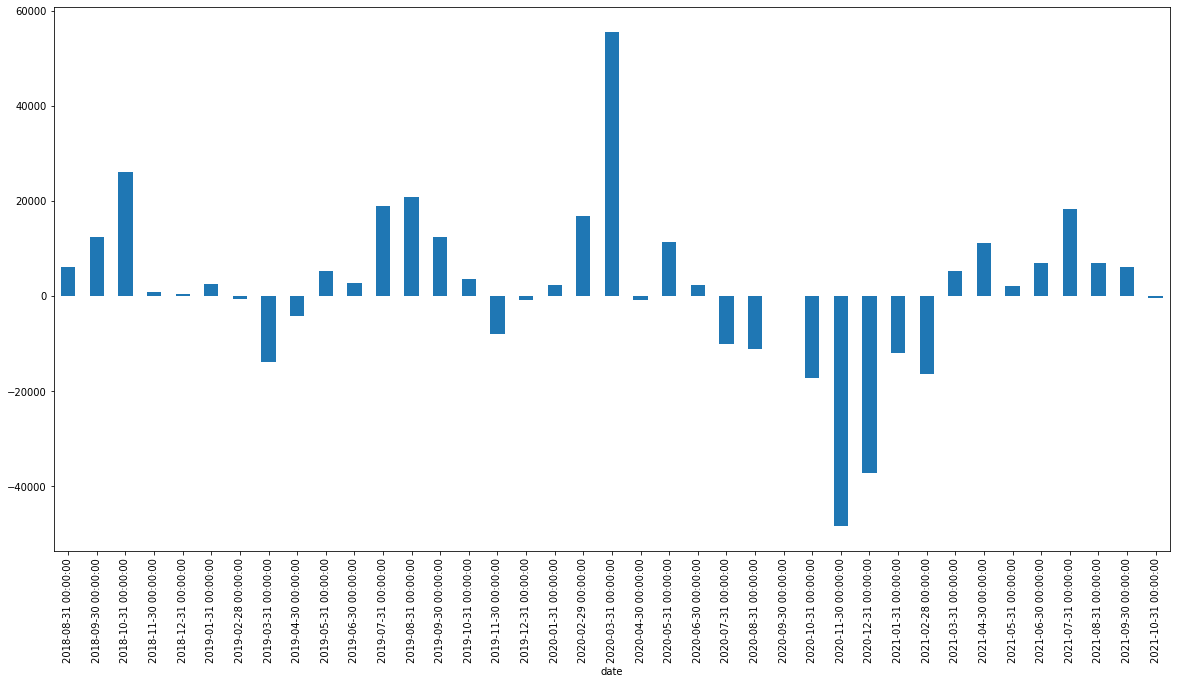

In [36]:
fii_fig.DIIcash.resample('M').sum().plot(kind='bar',figsize=(20,10))
plt.show()

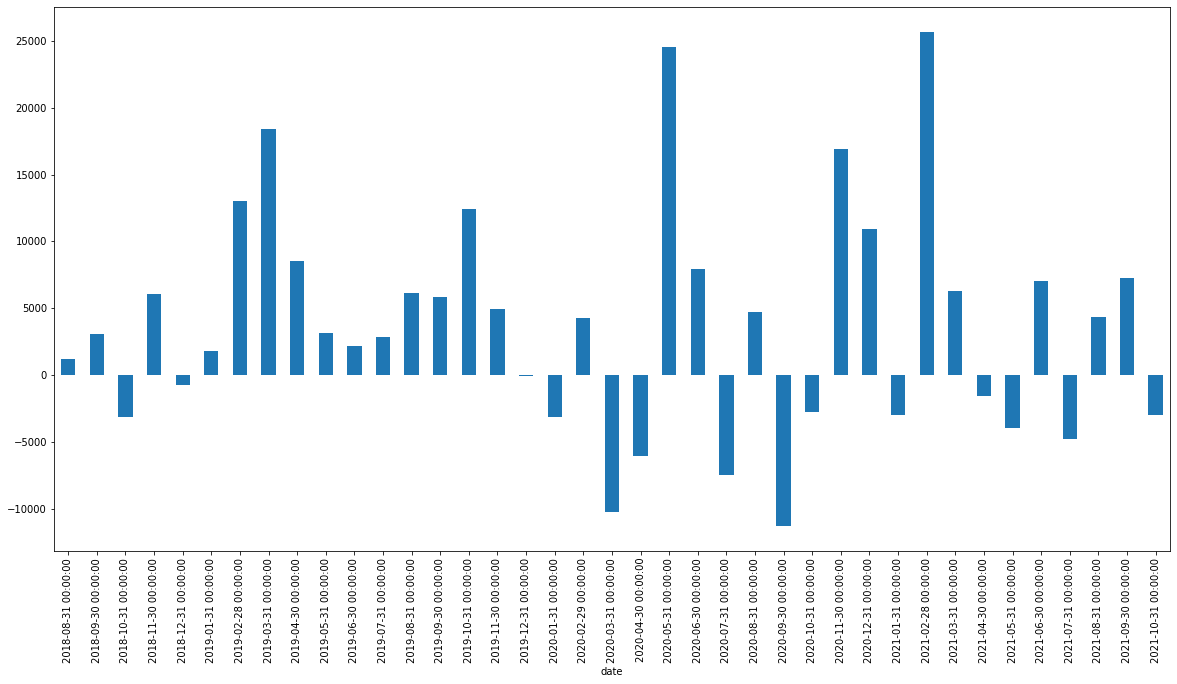

In [37]:
fii_fig.Cash.resample('M').sum().plot(kind='bar',figsize=(20,10))
plt.show()


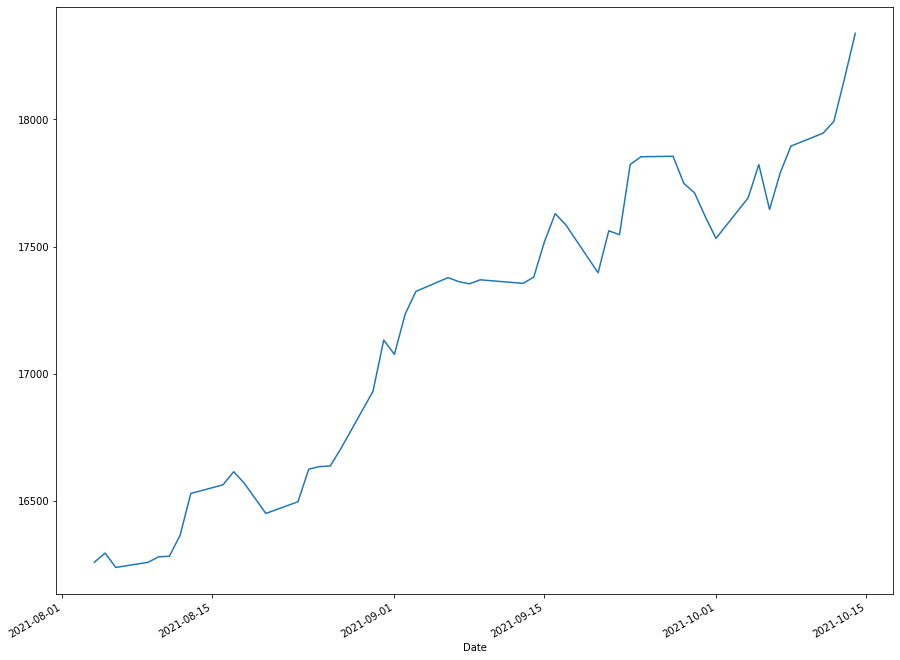

In [38]:
nifty['Close'][-50:].plot(figsize=(15,12))

In [39]:
fii_fig['MA200']=fii_fig.FIICash.rolling(window=200).mean()
fii_fig['MA50']=fii_fig.FIICash.rolling(window=50).mean()

In [40]:
fii_fig['macd']=fii_fig['FIICash'].ewm(span=50, adjust=False).mean()-fii_fig['FIICash'].ewm(span=200, adjust=False).mean()
fii_fig['signal']=fii_fig['macd'].ewm(span=35,adjust=False).mean()
fii_fig['signal10']=fii_fig['macd'].ewm(span=10,adjust=False).mean()
fii_fig['hist']=fii_fig['macd']-fii_fig['signal'] 


In [41]:
fii_fig['macd_dom']=fii_fig['DIIcash'].ewm(span=100, adjust=False).mean()-fii_fig['DIIcash'].ewm(span=200, adjust=False).mean()
fii_fig['signal_dom']=fii_fig['DIIcash'].ewm(span=50,adjust=False).mean()
fii_fig['hist_dom']=fii_fig['macd_dom']-fii_fig['signal_dom']

In [42]:


# sample dataset from plotly express
df = fii_fig
# Filter and pivot dataset for each country,
# and add lines for each country
fig = go.Figure()
for c in ['macd','signal']:
    fig.add_traces(go.Scatter(x=df.index, y=df[c], mode='lines', name = c))

fig.show()

# Plot Smart Money (FII)

In [43]:
from plotly.subplots import make_subplots
df=fii_fig.reset_index()
fig = make_subplots(
    rows=2, cols=1,shared_xaxes=True,vertical_spacing=0.02,
    subplot_titles=("Smart Money","Nifty"))

fig.add_trace(go.Scatter(x=df.Date, y=df['macd'], mode='lines', name = 'macd'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df['signal'], mode='lines', name = 'signal'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['signal10'], mode='lines', name = 'signal10'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=nif.Date, y=nif['Close'], mode='lines', name = 'Close'),
              row=2, col=1)

fig.update_layout(title_text="Smart Money And Nifty")

fig.show()

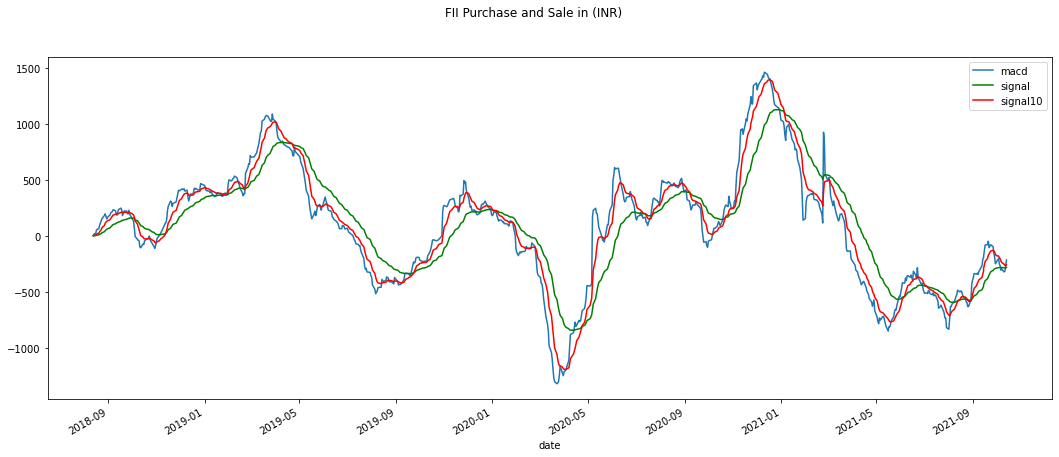

In [44]:
fii_fig['macd'].plot(figsize=(18,7))
fii_fig['signal'].plot(color='g')
fii_fig['signal10'].plot(color='r')
#plt.plot(fii_fig.loc[:, :].index)
plt.suptitle('FII Purchase and Sale in (INR)')
plt.legend()
plt.show()


In [45]:
fii_fig['fsig']=np.where(fii_fig['macd']>fii_fig['signal10'],1,0)

In [46]:
fii_fig['fsig'].tail(20)

date
2021-09-17    1
2021-09-20    1
2021-09-21    1
2021-09-22    1
2021-09-23    1
2021-09-24    1
2021-09-27    1
2021-09-28    0
2021-09-29    0
2021-09-30    0
2021-10-01    0
2021-10-04    0
2021-10-05    0
2021-10-06    0
2021-10-07    0
2021-10-08    0
2021-10-11    0
2021-10-12    0
2021-10-13    0
2021-10-14    1
Name: fsig, dtype: int64

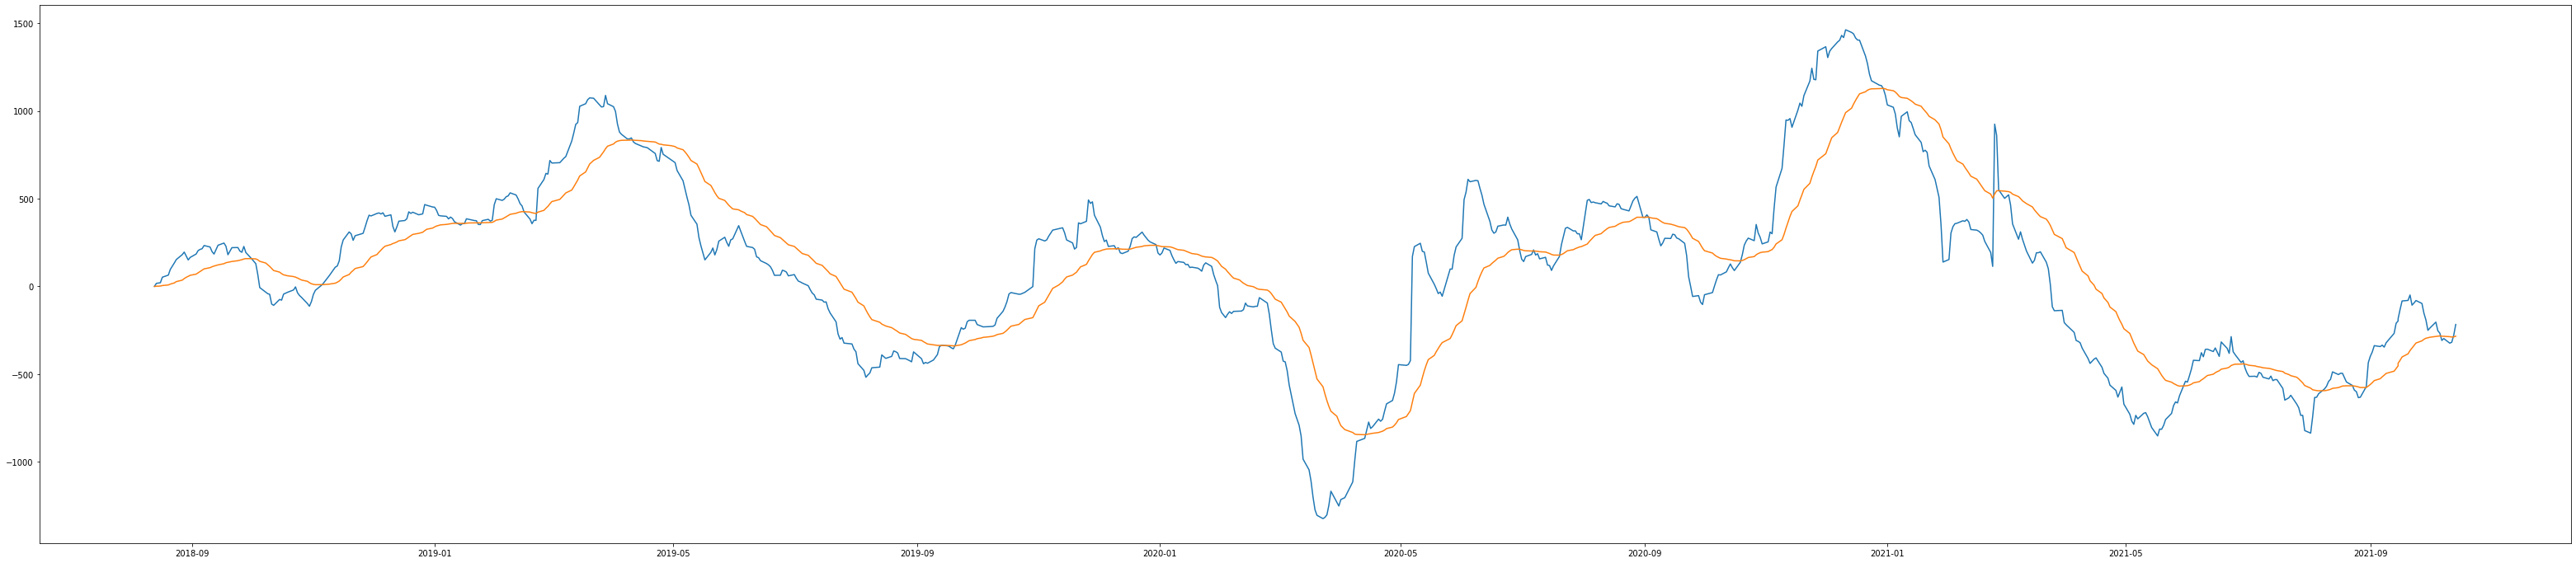

In [47]:
plt.figure(figsize=(55,12))
plt.plot(fii_fig.loc[:, :].index,fii_fig['macd'],label='MACD')
plt.plot(fii_fig.loc[:, :].index,fii_fig['signal'],label='Signal')
#plt.plot(fii_fig.loc[:, :].index)
plt.show()

In [48]:
nifty=nifty.reset_index()

In [49]:
nif.shape,df.macd.shape

((780, 7), (782,))

In [50]:
sample= pd.concat([nif['Close'] ,df['signal']][-len(nif):],axis=1)
sample=sample.replace(0,0.1)

In [51]:
sample['pct_chg']=sample['Close'].pct_change()
sample['macd_chg']=sample['signal'].pct_change()


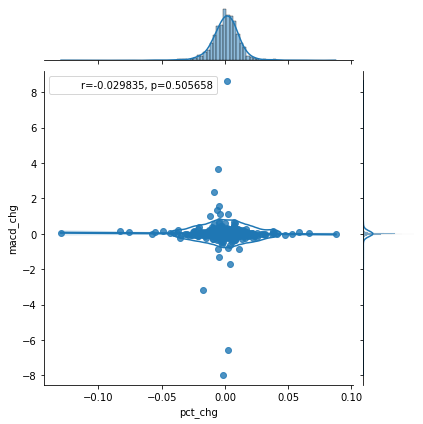

In [52]:
import seaborn as sns
from scipy.stats import pearsonr
g=sns.jointplot(x='pct_chg',y='macd_chg',data=sample,kind='reg').plot_joint(sns.kdeplot,n_levels=6)
r, p = pearsonr(sample['pct_chg'][-500:], sample['macd_chg'][-500:])
phantom, = g.ax_joint.plot([], [], linestyle="", alpha=0)
g.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])
plt.show()

# Call n Put Purchase/Sale

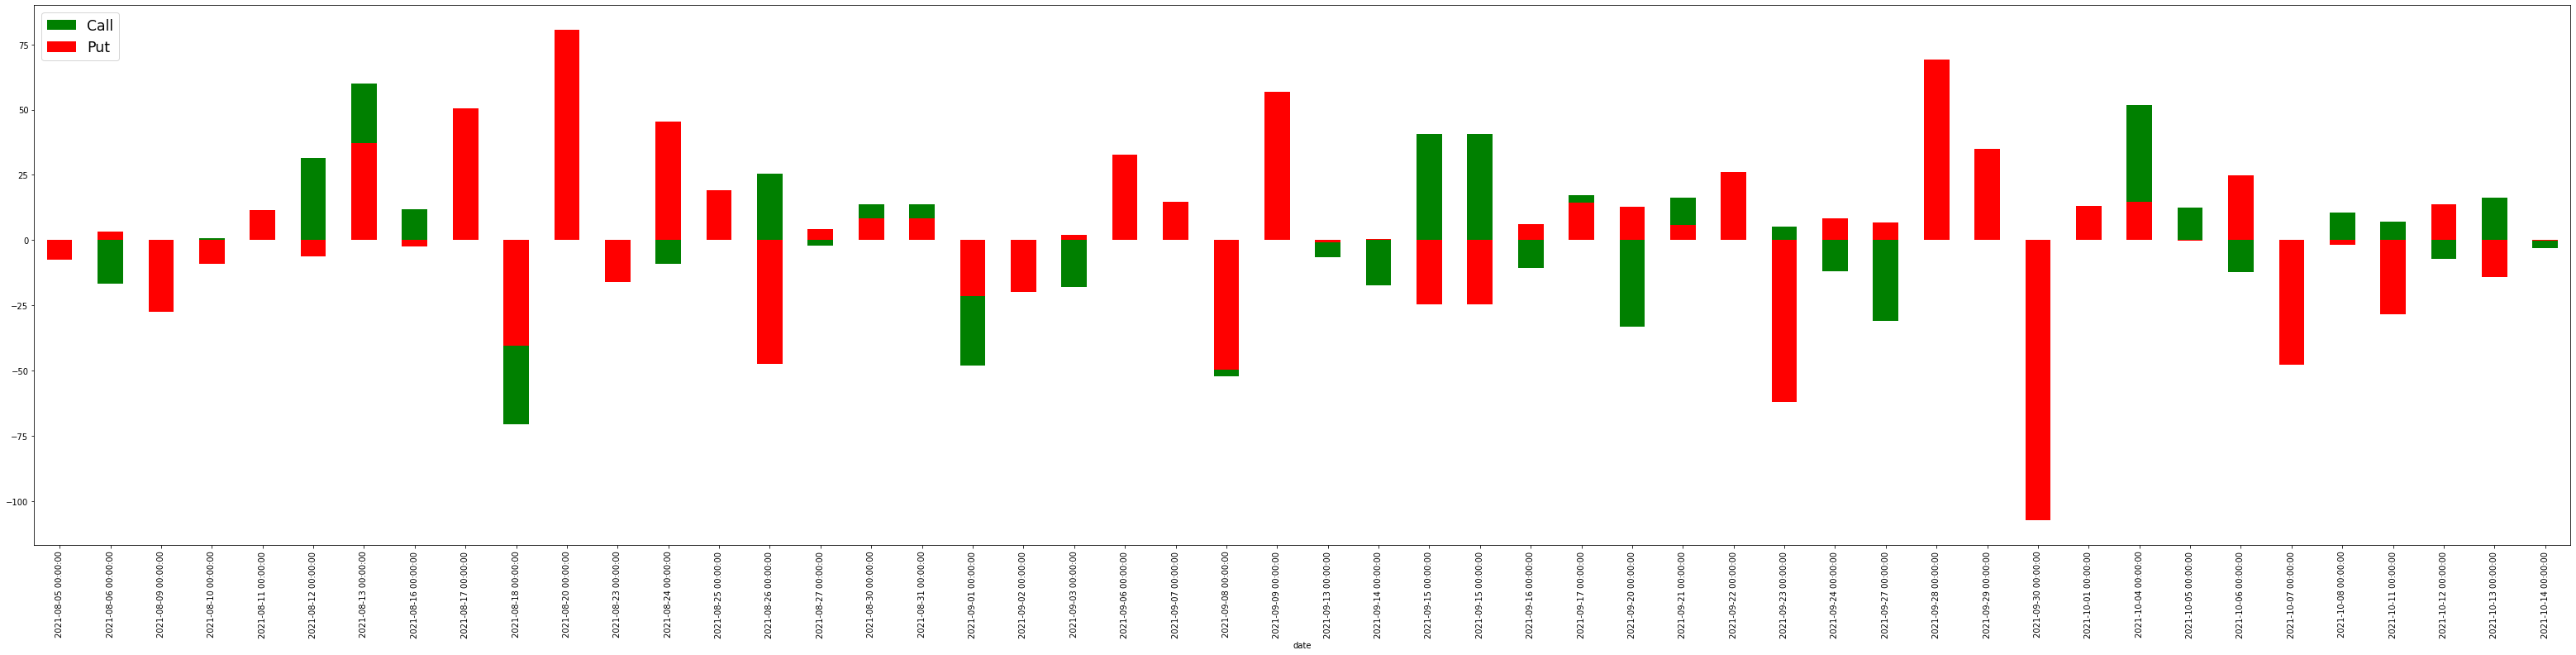

In [53]:
#fii_fig['FIIcall'][-200:].plot(kind='line',figsize=(55,12))
fii_fig['FIIcall'][-50:].plot(color='g',kind='bar',figsize=(55,12),label='Call')

fii_fig['FIIput'][-50:].plot(color='r',kind='bar',figsize=(55,12),label='Put')
plt.legend(loc='upper left',fontsize='xx-large')
plt.show()


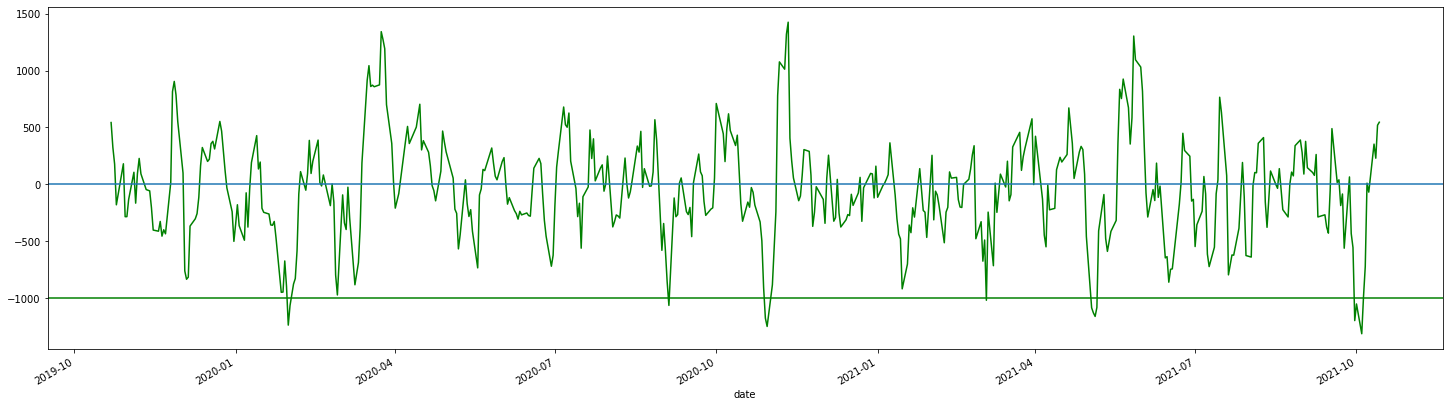

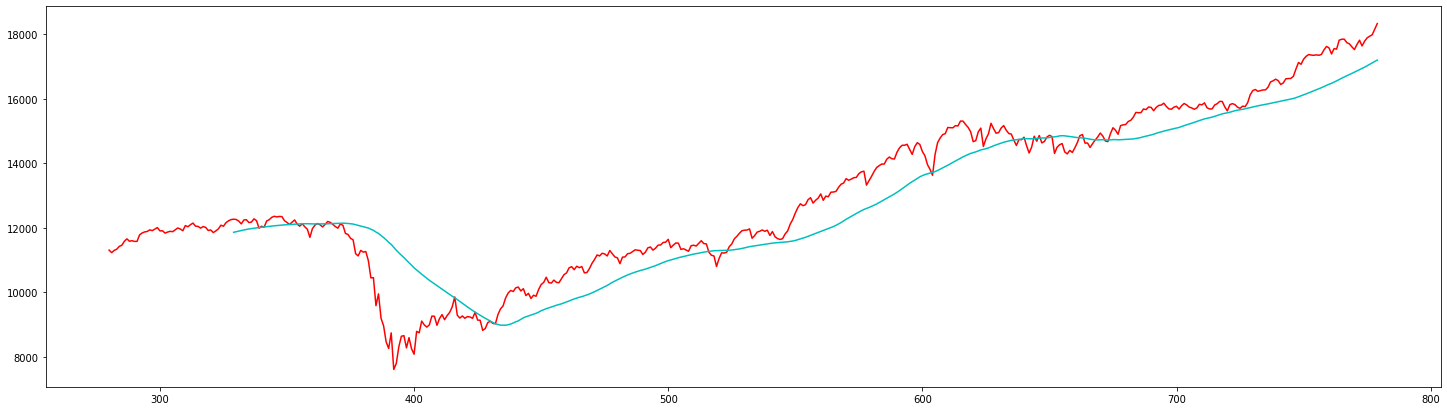

In [54]:
#fii_fig['FIIFuture'][-100:].plot(color='g',kind='line',figsize=(55,12))
fii_fig['FIIFuture'][-500:].rolling(window=5).mean().plot(color='g',kind='line',figsize=(25,7))
plt.axhline(y=0)
plt.axhline(y=-1000, color='g')
plt.show()
nifty['Close'][-500:].plot(color='r',kind='line',figsize=(25,7))
nifty['Close'][-500:].rolling(window=50).mean().plot(color='c',kind='line',figsize=(25,7))
plt.show()

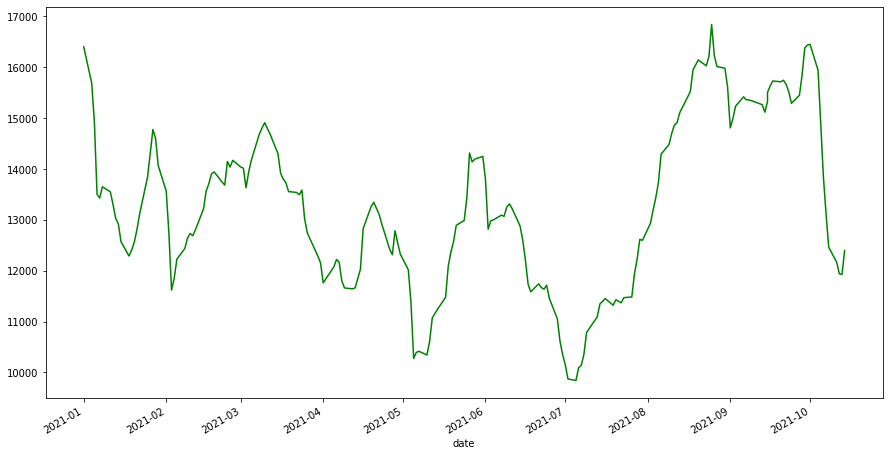

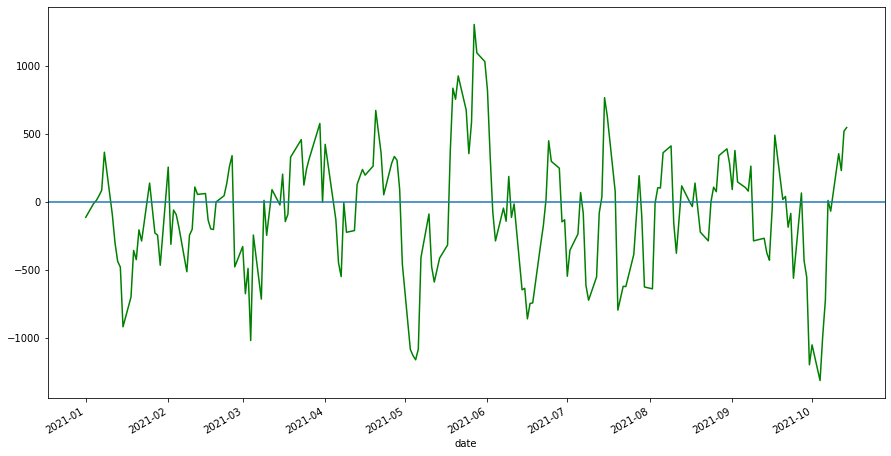

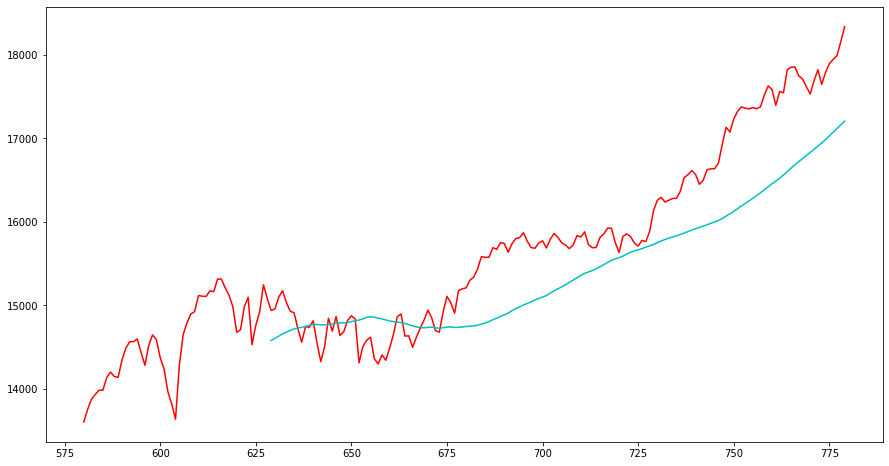

In [55]:
#fii_fig['FIIFuture'][-100:].plot(color='g',kind='line',figsize=(55,12))
fii_fig['FIIFutOI'][-200:].rolling(window=5).mean().plot(color='g',kind='line',figsize=(15,8))
plt.show()
fii_fig['FIIFuture'][-200:].rolling(window=5).mean().plot(color='g',kind='line',figsize=(15,8))
plt.axhline(y=0)
plt.show()
nifty['Close'][-200:].plot(color='r',kind='line',figsize=(15,8))
nifty['Close'][-200:].rolling(window=50).mean().plot(color='c',kind='line',figsize=(15,8))
plt.show()

In [56]:
def calculate_features(fii):
  fii['macd_dom']=fii['DIIcash'].ewm(span=25, adjust=False).mean()-fii['DIIcash'].ewm(span=50, adjust=False).mean()
  fii['signal_dom']=fii['macd_dom'].ewm(span=10,adjust=False).mean()
  fii['signal10_dom']=fii['macd_dom'].ewm(span=5,adjust=False).mean()
  fii['hist_dom']=fii['macd_dom']-fii['signal_dom']
  fii['macd_fii']=fii['FIICash'].ewm(span=25, adjust=False).mean()-fii['FIICash'].ewm(span=50, adjust=False).mean()
  fii['signal_fii']=fii['macd_fii'].ewm(span=10,adjust=False).mean()
  fii['signal10_fii']=fii['macd_fii'].ewm(span=5,adjust=False).mean()
  fii['hist_fii']=fii['macd_fii']-fii['signal_fii']
  fii_fig['FII_fut_mov_avg']=fii_fig['FIIFuture'].rolling(10).mean()
  fii_fig['FII_fut_mov_avg20']=fii_fig['FIIFuture'].rolling(20).mean()
  fii_fig['FII_fut_mov_avg40']=fii_fig['FIIFuture'].rolling(40).mean()
  return fii

In [57]:
fii=fii.set_index('Date')

In [58]:
data_int=int(len(fii)*0.8)
data_0=fii[:data_int]
train_0=int(len(data_0)*.75)
df_train_0= data_0[:train_0]
df_test_0= data_0[train_0+50:]
df_train=calculate_features(df_train_0)
df_test=calculate_features(df_test_0)

In [59]:
days_out=14
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df_train['Signal_Flag'] = df_train['Close'].transform(lambda x : np.sign(x.diff(days_out)))

df_train = df_train.dropna()

In [60]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df_test['Signal_Flag'] = df_test['Close'].transform(lambda x : np.sign(x.diff(days_out)))

df_test = df_test.dropna()

In [61]:
X_train = df_train.drop(['Signal_Flag'],axis=1)
y_train = df_train['Signal_Flag']
X_test = df_test.drop(['Signal_Flag'],axis=1)
y_test = df_test['Signal_Flag']

In [62]:
'''
# Number of trees is not a parameter that should be tuned, but just set large enough usually. There is no risk of overfitting in random forest with growing number of # trees, as they are trained independently from each other. 
n_estimators = list(range(20, 200, 20))

# Number of features to consider at every split
max_features = ['auto', 'sqrt', None, 'log2']

# Maximum number of levels in tree
# Max depth is a parameter that most of the times should be set as high as possible, but possibly better performance can be achieved by setting it lower.
max_depth = list(range(10, 50, 10))
max_depth.append(None)

# Minimum number of samples required to split a node
# Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree. Too high values can also lead to # under-fitting hence depending on the level of underfitting or overfitting, you can tune the values for min_samples_split.
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2,3,4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)
'''

"\n# Number of trees is not a parameter that should be tuned, but just set large enough usually. There is no risk of overfitting in random forest with growing number of # trees, as they are trained independently from each other. \nn_estimators = list(range(20, 200, 20))\n\n# Number of features to consider at every split\nmax_features = ['auto', 'sqrt', None, 'log2']\n\n# Maximum number of levels in tree\n# Max depth is a parameter that most of the times should be set as high as possible, but possibly better performance can be achieved by setting it lower.\nmax_depth = list(range(10, 50, 10))\nmax_depth.append(None)\n\n# Minimum number of samples required to split a node\n# Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree. Too high values can also lead to # under-fitting hence depending on the level of underfitting or overfitting, you can tune the values for min_samples_split.\nmin_samples_split = [2, 5, 10

In [63]:
'''
# New Random Forest Classifier to house optimal parameters
rf = RandomForestClassifier()

# Specfiy the details of our Randomized Search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model############################~~~~~~~~~~~~~~~~~~################
rf_random.fit(X_train, y_train)
print(f"Best score: {rf_random.best_score_}")
print("Best parameters set:")
best_parameters = rf_random.best_estimator_.get_params()
for param_name in sorted(random_grid.keys()):
  print(f"\t{param_name}: {best_parameters[param_name]}")
'''

'\n# New Random Forest Classifier to house optimal parameters\nrf = RandomForestClassifier()\n\n# Specfiy the details of our Randomized Search\nrf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)\n\n# Fit the random search model############################~~~~~~~~~~~~~~~~~~################\nrf_random.fit(X_train, y_train)\nprint(f"Best score: {rf_random.best_score_}")\nprint("Best parameters set:")\nbest_parameters = rf_random.best_estimator_.get_params()\nfor param_name in sorted(random_grid.keys()):\n  print(f"\t{param_name}: {best_parameters[param_name]}")\n'

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   52.0s finished
Best score: 0.7501164849501444
Best parameters set:
	bootstrap: True
	max_depth: 10
	max_features: auto
	min_samples_leaf: 1
	min_samples_split: 5
	n_estimators: 180

In [64]:
# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 180,max_depth=10,min_samples_leaf=1,max_features='auto', min_samples_split=5, criterion = "gini", bootstrap=True,random_state = 42)
# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

In [65]:
# Print the Accuracy of our Model.
print('Correct Prediction RForest (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction RForest (%):  67.74193548387096


In [66]:
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_imp*100

macd_dom        18.025560
signal10_dom    14.181527
signal_dom      10.094356
signal10_fii     7.580541
Close            6.851967
signal_fii       6.109233
Index            5.230195
FIIFutOI         4.884692
index            4.735245
macd_fii         4.510723
hist_dom         3.804300
DIIcash          3.039445
FIICash          2.471950
FIIFuture        2.236457
FIIput           2.206649
FIIcall          2.158767
hist_fii         1.878394
dtype: float64

In [67]:
features=X_train.columns

In [68]:
real=fii[data_int:]

In [69]:
df_real=calculate_features(real)

In [70]:
price_data_new =df_real.copy()

In [71]:
# Group by the `Symbol` column, then grab the `Close` column.
close_groups = df_real['Close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff(days_out)))

# add the data to the main dataframe.
price_data_new['Signal_Flag'] = close_groups
price_data_new = price_data_new.dropna()

In [72]:
ppp =price_data_new.reset_index()

In [73]:
pred = pd.DataFrame(rand_frst_clf.predict(price_data_new[features]))
pred = pd.concat([pred , ppp.Date,ppp['Close']],axis=1)
pred.columns=['pred','date','Close']
pred= pred.set_index('date')

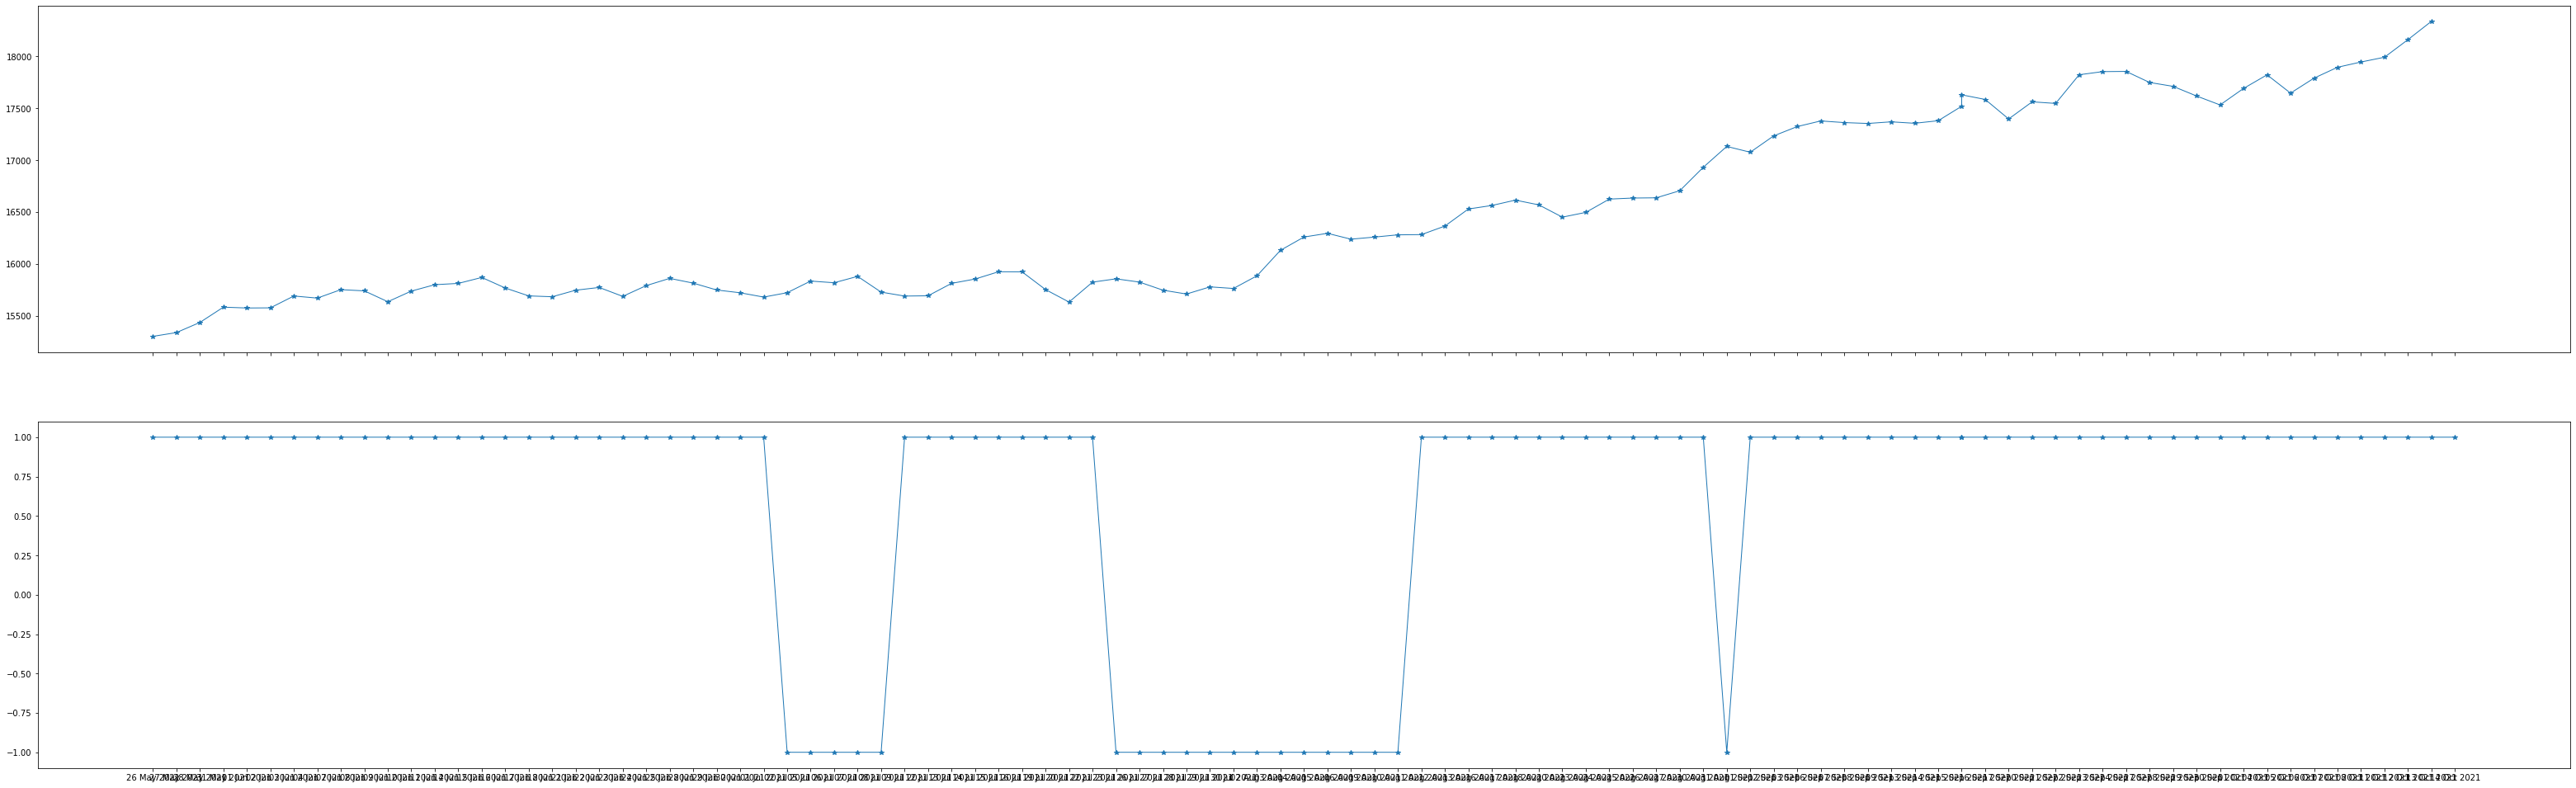

In [74]:
fig, ax = plt.subplots(2,1,figsize=(55,17),sharex=True)
ax[0].plot(df_real.index.values[-100:],df_real['Close'].values[-100:],'*-',linewidth=1 )
ax[1].plot(df_real.index.values[-100:],pred.pred.values[-100:],'*-',linewidth=1 )
#plt.xticks(fontsize=12, rotation=90)
plt.show()

In [75]:
pred=pred.reset_index()

In [76]:
#fig, ax = plt.subplots(1,1,figsize=(20,7))
#Identifying the buy/sell zone
pred['Buy_ind'] = np.where((pred['pred']==1), 1, 0)
pred['Sell_ind'] = np.where((pred['pred']==-1), 0, 1)

In [77]:
df_real['15_EMA'] = df_real['Close'].rolling(15).mean()
df_real['30_EMA'] = df_real['Close'].rolling(30).mean()

In [78]:

l=len(pred)

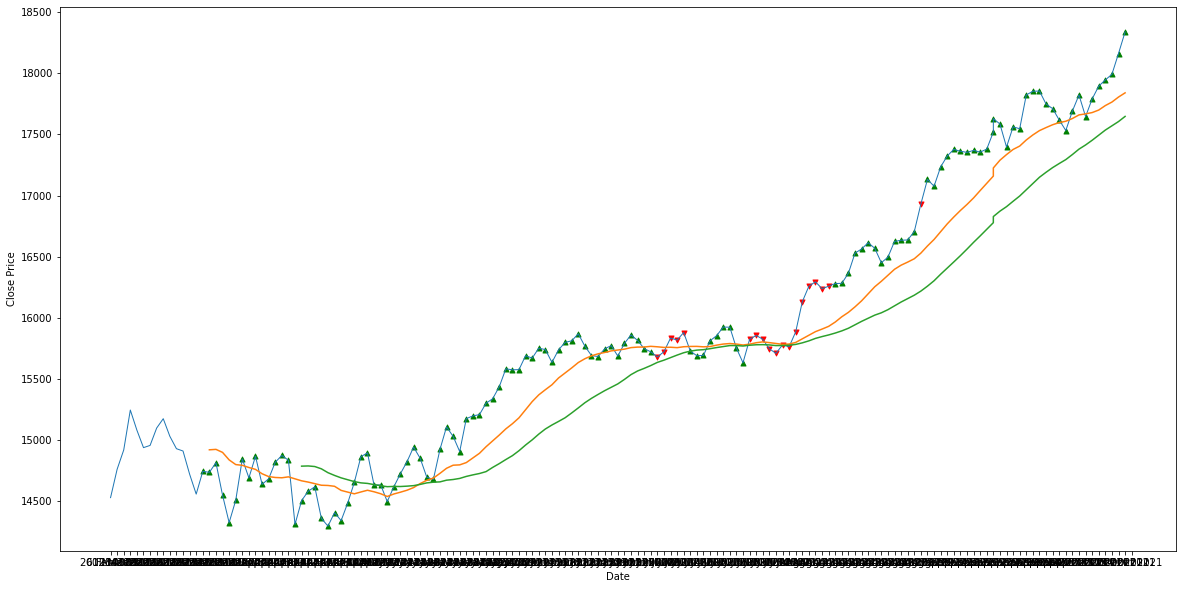

In [79]:
plt.figure(figsize=(20,10))
## plotting the buy and sell signals on graph
plt.plot(df_real.index.values[:],df_real['Close'].values[:],'-',linewidth=1)
plt.scatter(pred.loc[pred['Buy_ind'] ==1 , 'date'].values,pred.loc[pred['Buy_ind'] ==1, 'Close'].values, label='skitscat', color='green', s=25, marker="^")
plt.scatter(pred.loc[pred['Sell_ind'] ==0 , 'date'].values,pred.loc[pred['Sell_ind'] ==0, 'Close'].values, label='skitscat', color='red', s=25, marker="v")
plt.plot(df_real.index.values[-l:],df_real['15_EMA'].values[-l:])
plt.plot(df_real.index.values[-l:],df_real['30_EMA'].values[-l:])
## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
#plt.title('AD Nifty price with buy and sell signal ' ) 
#plt.xticks(fontsize=1, rotation=90)
#plt.savefig('a.png')
plt.show();